<a href="https://colab.research.google.com/github/babymlin/t-SNE_Grad-CAM/blob/main/Grad_CAM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.applications import imagenet_utils
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import os
tf.__version__

'2.5.0'

In [2]:
IMG_SIZE = 299

In [3]:
model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [32]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [33]:
def gradcam(model, img, layer_name='mixed10'):
    # get pred class idx
    preds = model.predict(img)
    pred_class_idx = np.argmax(preds[0])
    #imagenet_utils.decode_predictions:可以取得imagenet的label名稱
    pred_class_name = imagenet_utils.decode_predictions(preds)[0][0][1]

    # build a new model for Grad-CAM
    outputs = [model.get_layer(layer_name).output]
    outputs.append(model.output)
    model_gradcam = models.Model([model.inputs], outputs) 
    # input: img, output: [layer_output, class_output]
    
    with tf.GradientTape() as tape:
        conv_output, preds = model_gradcam(img)
        pred_output = preds[:, pred_class_idx]
        grads = tape.gradient(pred_output, conv_output)
        print('conv_output.shape', conv_output.shape)
        print('grads.shape', grads.shape)
    
    pooled_grads = tf.keras.backend.sum(grads, axis=(0, 1, 2)) # (2048, )
    print('pooled_grads.shape ', pooled_grads.shape)
    heatmap = pooled_grads * conv_output
    print('heatmaps.shape ', heatmap.shape)
    heatmap = tf.keras.backend.mean(heatmap, axis=-1)[0, :, :].numpy()
    
    return heatmap, pred_class_name

In [34]:
def processing_image(img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x = np.expand_dims(img, axis=0)
    
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    return x

In [35]:
def plot_heatmap(heatmap, img_path):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    # ReLU
    heatmap = np.maximum(heatmap, 0)
    
    # normalization
    heatmap /= np.max(heatmap)

    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)

    # show input img
    plt.figure(figsize=(10, 5))    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    # show heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(img) # original img
    plt.imshow(heatmap, cmap='jet', alpha=0.6) # heatmap
    plt.show()

conv_output.shape (1, 8, 8, 192)
grads.shape (1, 8, 8, 192)
pooled_grads.shape  (192,)
heatmaps.shape  (1, 8, 8, 192)
pred_class_name:  Siberian_husky img_path:  husky2.jpeg
heatmap.shape:  (8, 8)


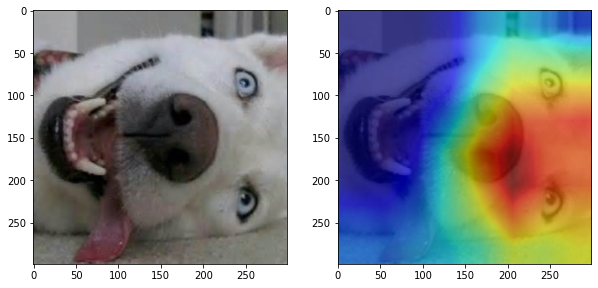

In [39]:
import os
i = random.choice(range(1,4))
FOLDER_PATH = ""
img_path = os.path.join(FOLDER_PATH, f'husky{i}.jpeg')
#img_path = os.path.join(FOLDER_PATH, f'cock1.jpeg')
#img_path = os.path.join(FOLDER_PATH, f'tennis.jpeg')

img = processing_image(img_path)
heatmap, pred_class_name = gradcam(model, img, 'conv2d_93')
print('pred_class_name: ', pred_class_name, 'img_path: ', img_path)
print('heatmap.shape: ', heatmap.shape)
plot_heatmap(heatmap, img_path)